# Create grids masks for different country groupdings

- WHO regions
- HDI classification
- Income group (?)

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import xarray as xr
import matplotlib.pyplot as plt

from config import POP_DATA_SRC, DATA_SRC

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['figure.figsize'] = (5, 2.7)
plt.rcParams['figure.titlesize'] = 'medium'
plt.rcParams['axes.titlesize'] = 'medium'
plt.rcParams['legend.fontsize'] = 'small'
# IMPORTANT TO SET THIS
xr.set_options(keep_attrs=True)

In [3]:
GPW_FILE = DATA_SRC/ 'lancet/population/UN WPP-Adjusted Population Count v4.11 2000-2020 15min era compat.nc'
COUNTRY_ID_LOOKUP = DATA_SRC/ 'lancet/population/gpwv4/gpw_v4_national_identifier_lookup.txt'


In [4]:
gpw_ds = xr.open_dataset(GPW_FILE)

## Load Lancet standardisation data

In [5]:
SD_FOLDER = Path('../../Standardisation guidelines - LIVE FOR AUTHORS')

In [6]:
# country_classification = pd.read_excel(SD_FOLDER / 'Country names - ISO3 codes - WHO and HDI classifications2021.xlsx', skiprows=1)
country_classification = pd.read_csv(SD_FOLDER / 'Country names - ISO3 codes - WHO and HDI classifications2021.csv', skiprows=1)

In [7]:
country_classification

Preferred Country Name ISO ALPHA-3 code             WHO Region  \
0              Afghanistan              AFG  Eastern Mediterranean   
1                  Albania              ALB               European   
2                  Algeria              DZA                African   
3                  Andorra              AND               European   
4                   Angola              AGO                African   
..                     ...              ...                    ...   
191                Vanuatu              VUT        Western Pacific   
192                Vietnam              VNM        Western Pacific   
193                  Yemen              YEM  Eastern Mediterranean   
194                 Zambia              ZMB                African   
195               Zimbabwe              ZWE                African   

    Level of human development  HDI rank 2019  \
0                          Low          169.0   
1                         High           69.0   
2                         High           91.0   
3                    Very High           36.0   
4                       Medium          148.0   
..                         ...            ...   
191                     Medium          140.0   
192                       High          117.0   
193                        Low          179.0   
194                     Medium          146.0   
195                     Medium          150.0   

    Human Development Index (HDI) 2019 Life expectancy at birth 2019  \
0                                0.511                         64.83   
1                                0.795                         78.57   
2                                0.748                         76.88   
3                                0.868                         81.91   
4                                0.581                         61.15   
..                                 ...                           ...   
191                              0.609                         70.47   
192                              0.704                          75.4   
193                               0.47                         66.13   
194                              0.584                         63.89   
195                              0.571                         61.49   

    Expected years of schooling 2019 Mean years of schooling 2019  \
0                           10.17643                         3.93   
1                           14.69562                     10.14573   
2                        14.60430179                  7.986547848   
3                        13.30023874                     10.50176   
4                          11.777202                  5.173993233   
..                               ...                          ...   
191                         11.73391                     7.064846   
192                        12.692323                         8.32   
193                          8.76899                          3.2   
194                        11.478083                     7.152016   
195                        10.968732                       8.4668   

    Gross national income (GNI) per capita 2019 2019  \
0                                        2229.362021   
1                                        13998.29989   
2                                        11173.95681   
3                                        56000.30336   
4                                         6104.05464   
..                                               ...   
191                                      3104.799016   
192                                      7432.706806   
193                                      1593.704031   
194                                      3325.518591   
195                                      2665.612042   

    GNI per capita rank minus HDI rank 2019  
0                                         0  
1                                        18  
2                                        13  
3                      

## Load country data

In [7]:
COUNTRIES_RASTER = gpw_ds['National Identifier Grid, v4.11 (2010): National Identifier Grid'].load()

In [8]:
COUNTRIES_LOOKUP = pd.read_csv(COUNTRY_ID_LOOKUP,sep='\t')

In [9]:
COUNTRIES_LOOKUP = COUNTRIES_LOOKUP.set_index('ISOCODE').join(country_classification.set_index('ISO ALPHA-3 code'))

In [10]:
COUNTRIES_LOOKUP.head()

GRIDCODE  UNSDCODE           NAME0  CIESINCODE  \
ISOCODE                                                   
AFG             4         4     Afghanistan           4   
ALB             8         8         Albania           8   
DZA            12        12         Algeria          12   
ASM            16        16  American Samoa          16   
AND            20        20         Andorra          20   

                               DATATYPE  DATACODE  DATAYEAR  DATALEVEL  \
ISOCODE                                                                  
AFG      Population estimate/projection         6      2011          2   
ALB                        Final census         1      2011          3   
DZA                        Final census         1      2008          2   
ASM                        Final census         1      2010          3   
AND                 Population register         5      2010          1   

         GRSTART  GREND  GRLEVEL  LASTCENSUS    MEANUNITKM  \
ISOCODE                                                      
AFG         1998   2011        1        1979   4507.466751   
ALB         2001   2011        3        2011    115.949835   
DZA         1998   2008        2        2008  50884.794880   
ASM         2000   2010        3        2010      7.612468   
AND         2000   2010        1        2011     79.902822   

        Preferred Country Name             WHO Region  \
ISOCODE                                                 
AFG                Afghanistan  Eastern Mediterranean   
ALB                    Albania               European   
DZA                    Algeria                African   
ASM                        NaN                    NaN   
AND                    Andorra               European   

        Level of human development  Human Development Index in 2018 (HDI)  \
ISOCODE                                                                     
AFG                            Low                               0.495960   
ALB                           High                               0.791406   
DZA                           High                               0.758978   
ASM                            NaN                                    NaN   
AND                      Very High                               0.856781   

         HDI rank  
ISOCODE            
AFG         170.0  
ALB          69.0  
DZA          82.0  
ASM           NaN  
AND          36.0

In [15]:
world_map_data = gpd.read_file(SD_FOLDER/ 'Shapefiles' / 'detailed_2013.shp').set_index('ISO_3_CODE')

In [98]:
def raster_for_regions(classif_name, regions_class=None):
    if regions_class is None:
        regions_class = COUNTRIES_LOOKUP[classif_name].unique()
        regions_class = [r for r in regions_class if r is not np.nan]

    results_coded = COUNTRIES_RASTER.copy()
    results_coded.data [:] = np.nan

    for i, region in enumerate(regions_class):
        region_countries = COUNTRIES_LOOKUP[COUNTRIES_LOOKUP[classif_name] == region]
        country_mask = None
        for _, row in region_countries.iterrows():
            grid_code = row.GRIDCODE
            if country_mask is None:
                country_mask = COUNTRIES_RASTER == grid_code
            else:
                # Combine the country mask of the current country with the overall one using bitwise 'OR'
                _cmask = COUNTRIES_RASTER == grid_code
                country_mask = country_mask | _cmask

        results_coded = xr.where(country_mask, (country_mask * i), results_coded)
        
    results_coded.name = classif_name
    results_coded.attrs[classif_name.lower().replace(' ', '_')] = regions_class
    return results_coded

## Generate a raster for WHO regions

In [99]:
classif_name = 'WHO Region'

In [100]:
who = raster_for_regions(classif_name)

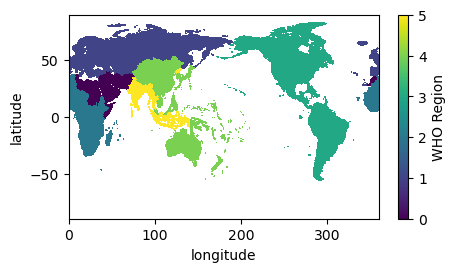

In [102]:
who.plot()

In [104]:
who.to_netcdf(POP_DATA_SRC / 'who_regions_15min_era_compat.nc')

In [105]:
who

<xarray.DataArray 'WHO Region' (latitude: 720, longitude: 1440)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75
Attributes:
    who_region:  ['Eastern Mediterranean', 'European', 'African', 'Americas',...

## Generate a raster for HDI classification

In [106]:
classif_name = 'Level of human development'

In [107]:
hdi = raster_for_regions(classif_name, ['Low', 'Medium', 'High', 'Very High'])

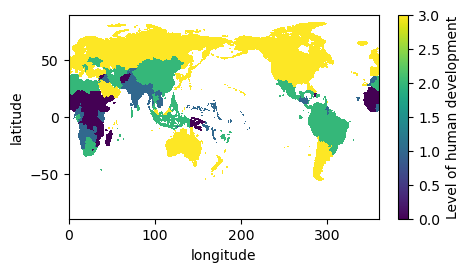

In [108]:
hdi.plot()

In [109]:
hdi

<xarray.DataArray 'Level of human development' (latitude: 720, longitude: 1440)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75
Attributes:
    level_of_human_development:  ['Low', 'Medium', 'High', 'Very High']

In [110]:
hdi.to_netcdf(POP_DATA_SRC / 'hdi_regions_15min_era_compat.nc')

## Add who and hdi to country

In [8]:
df = pd.read_csv('../results/heatwaves/heatwave_exposure_days_by_country.csv')

df = df.set_index('country').join(country_classification[['ISO ALPHA-3 code', 'WHO Region',
       'Level of human development']].set_index('ISO ALPHA-3 code') )

df.index.name ='country'
df.to_csv('../results/heatwaves/heatwave_exposure_days_by_country_w_hdi_who.csv')

In [9]:
df

year  heatwaves_days WHO Region Level of human development
country                                                            
ABW      1980   -9.398791e+03        NaN                        NaN
ABW      1981   -3.671281e+03        NaN                        NaN
ABW      1982   -9.859092e+03        NaN                        NaN
ABW      1983   -1.313800e+03        NaN                        NaN
ABW      1984   -1.019486e+04        NaN                        NaN
...       ...             ...        ...                        ...
ZWE      2016    4.626469e+06    African                     Medium
ZWE      2017   -1.292560e+06    African                     Medium
ZWE      2018   -7.565619e+05    African                     Medium
ZWE      2019    8.170519e+06    African                     Medium
ZWE      2020    4.658156e+06    African                     Medium

[10168 rows x 4 columns]

In [10]:
df = pd.read_csv('../results/heatwaves/heatwave_exposure_days_by_country_newborns.csv')

df = df.set_index('country').join(country_classification[['ISO ALPHA-3 code', 'WHO Region',
       'Level of human development']].set_index('ISO ALPHA-3 code') )

df.index.name ='country'
df.to_csv('../results/heatwaves/heatwave_exposure_days_by_country_newborns_w_hdi_who.csv')

In [11]:
df

year  heatwaves_days WHO Region Level of human development
country                                                            
ABW      1980   -2.836602e+03        NaN                        NaN
ABW      1981   -7.309861e+02        NaN                        NaN
ABW      1982   -2.861856e+03        NaN                        NaN
ABW      1983   -4.281890e+02        NaN                        NaN
ABW      1984   -2.850485e+03        NaN                        NaN
...       ...             ...        ...                        ...
ZWE      2016    4.197888e+06    African                     Medium
ZWE      2017   -1.076435e+06    African                     Medium
ZWE      2018   -7.460745e+05    African                     Medium
ZWE      2019    6.624942e+06    African                     Medium
ZWE      2020    3.617841e+06    African                     Medium

[10168 rows x 4 columns]